# Train detection model

## Imports

In [1]:
import gc
import re
import json
import copy
from tqdm.auto import tqdm
from collections.abc import Callable
from typing import Any

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, Dataset

from torchvision.transforms import v2
import albumentations as A

from doctr.models import detection
from doctr.datasets import DetectionDataset
from doctr import transforms as T

from castom_utils import (load_config,
                          Ansi, 
                          DeNormalize,
                          save_model,
                          DetectionDatasetCustom,
                          ColorShiftTorch,
                          ColorShiftAlb,
                          )

In [2]:
CFG = load_config()

Config is loaded!
List of all chars used (114):
0123456789!"'#%&()*+,-./:;<=>?@[\]^_{|}~№°$£€¥¢₽АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯабвгдеёжзийклмнопрстуфхцчшщъыьэюя


In [3]:
def draw_image_dataset(
    dataset, 
    normalize_params: dict | None = None, 
    model: nn.Module | None = None, 
    img_size=10
):
    """
    Вывод случайного элемента из torch dataset
    При передачи модели, будут отрисованы так же и предсказания.
    """
    idx = np.random.choice(len(dataset))
    title = f'idx: {idx}'
    print(title)
    
    image, target = dataset[idx]
    img = copy.deepcopy(image)

    height, width = img.shape[-2:]
    gt_boxes = target['words'] * np.array([width, height, width, height])
    gt_boxes = gt_boxes.astype(np.int32).tolist()

    if normalize_params is not None:
        denorm = DeNormalize(**normalize_params)
        img = denorm(img)
    
    img = (img * 255).to(torch.uint8)
    img = img.numpy().transpose(1, 2, 0)
    img = Image.fromarray(img)
    draw = ImageDraw.Draw(img)

    for bbox in gt_boxes:
        # draw.polygon([tuple(cord) for cord in bbox], outline='green', width=1) 
        draw.rectangle(bbox, outline='green', width=1)

    if model is not None:
        model.eval()
        with torch.no_grad():
            image = image.to(DEVICE).unsqueeze(0)
            output = model(image, [target], return_preds=True)

            pred_boxes = output['preds'][0]['words'][:, :4]
            pred_boxes = (pred_boxes * np.array([width, height, width, height])).astype(np.int32)
            loss = output['loss'].item()

        title += f', loss: {loss:.4f}'
        for bbox in pred_boxes:
            draw.rectangle(bbox.tolist(), outline='red', width=1)
    
    plt.figure(figsize=(img_size, img_size))
    plt.title(title)
    plt.imshow(img)
    plt.show()

In [4]:
SEED = 42

IS_CUDA = torch.cuda.is_available()
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'torch use: {Ansi.green}{Ansi.bold}{DEVICE}{Ansi.end}', 
      f'({torch.cuda.get_device_name()})' 
      if torch.cuda.is_available() else '')

torch use: cuda (AMD Radeon RX 7800 XT)


In [5]:
DATASET = CFG.dataset_synthetic.joinpath('detection')
BATCH_SIZE = 4

INPUT_SIZE = 1024
NORMALIZE_PARAMS = dict(mean=(0.798, 0.785, 0.772), std=(0.264, 0.2749, 0.287))

## Dataset

Cформируем датасет из заранее сгенерированных изображений. Процесс подготовки такого датасета рассмотрен в ноутбуке **[synthetic_datasets.ipynb](synthetic_datasets.ipynb)**.

In [430]:
bbox_params=A.BboxParams(format='albumentations', min_visibility=.06, label_fields=['labels'])

# Image + target augmentations
transforms_alb_train = A.Compose([
    A.LongestMaxSize(max_size=INPUT_SIZE, interpolation=cv2.INTER_LINEAR),
    A.ColorJitter(brightness=.4, contrast=.4, saturation=.4, hue=.4, p=.25),
    A.RandomSunFlare(flare_roi=(0, 0, 1, 1), src_radius=150,  p=.1),
    A.InvertImg(p=.1),
    ColorShiftAlb(min_val=.6, p=.9),
    A.ToGray(p=.2),
    A.Affine(rotate=(-2, 2), fit_output=True, border_mode=cv2.BORDER_CONSTANT, p=.7),
    A.ShiftScaleRotate(shift_limit=.15, scale_limit=0, rotate_limit=0, border_mode=cv2.BORDER_CONSTANT, p=.4),
    A.Perspective(scale=(.01, .03), fit_output=True, p=.6),
    A.GaussianBlur(blur_limit=(1, 3), p=.3),
    A.GaussNoise(std_range=(.05, .1), p=.2),
    A.ElasticTransform(alpha=5, sigma=50, p=.2),
    A.LongestMaxSize(max_size=INPUT_SIZE, interpolation=cv2.INTER_LINEAR),
    A.PadIfNeeded(INPUT_SIZE, INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0))
    ], bbox_params=bbox_params)

# Image augmentations
transforms_img_train=v2.Compose([
    v2.ToImage(),
    T.RandomApply(T.RandomShadow(), p=.2),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(**NORMALIZE_PARAMS),
])


transforms_alb_val = A.Compose([
    A.LongestMaxSize(max_size=INPUT_SIZE, interpolation=cv2.INTER_LINEAR),
    A.PadIfNeeded(INPUT_SIZE, INPUT_SIZE, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0))
    ], bbox_params=bbox_params)

transforms_img_val=v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(**NORMALIZE_PARAMS),
])

In [432]:
train_set = DetectionDatasetCustom(
    DATASET / 'train', 
    transforms_img_train, 
    transforms_alb_train
)

val_set = DetectionDatasetCustom(
    DATASET / 'val', 
    transforms_img_val, 
    transforms_alb_val
)

print(f'train size: {len(train_set)}')
print(f'val size:   {len(val_set)}')

train size: 2000
val size:   200


idx: 1873


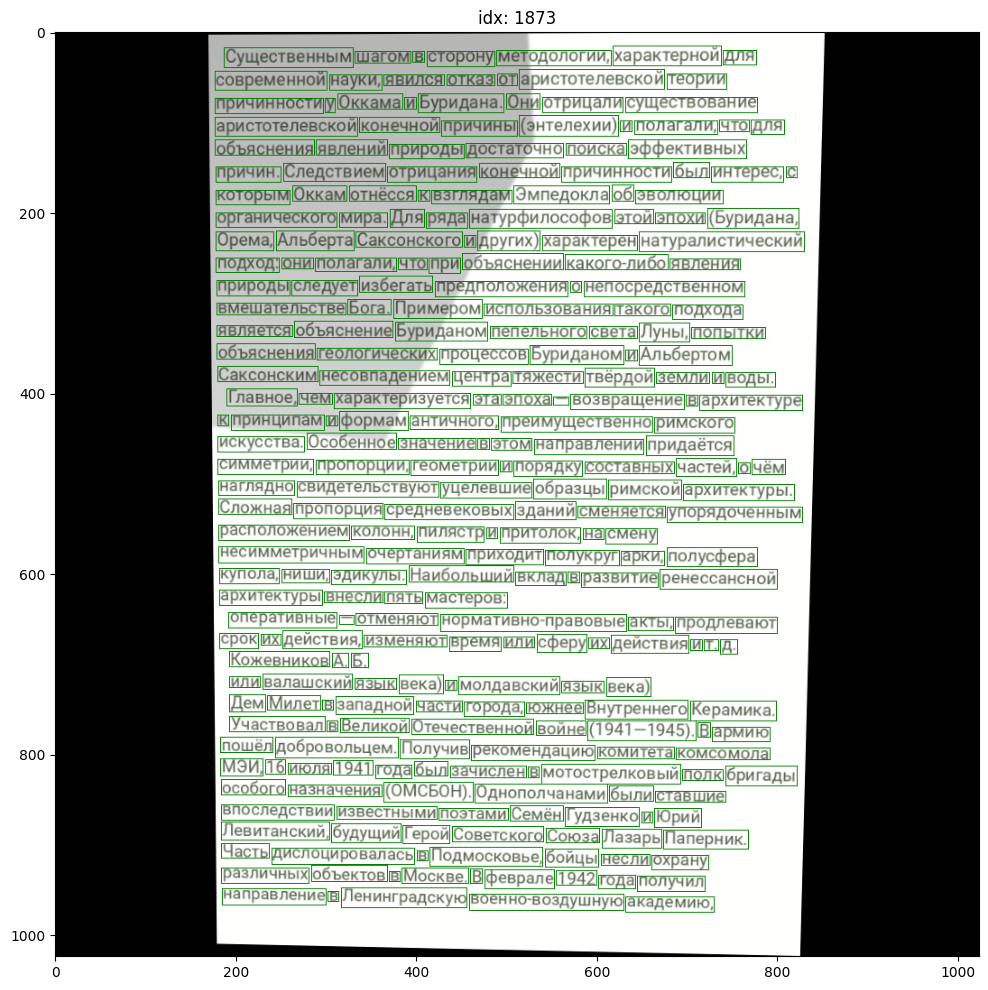

In [433]:
draw_image_dataset(train_set, NORMALIZE_PARAMS, img_size=12)

In [412]:
def collate_fn(samples: list[tuple[torch.Tensor, Any]]) -> tuple[torch.Tensor, list[Any]]:
    images, targets = zip(*samples)
    images = torch.stack(images, dim=0)
    return images, list(targets)


train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    drop_last=True,
    shuffle=True,
    pin_memory=IS_CUDA,
    collate_fn=collate_fn,
)

val_loader = DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    drop_last=False,
    shuffle=False,
    pin_memory=IS_CUDA,
    collate_fn=collate_fn,
)

Случайный пример изображения из тренировочного датасета с примененными аугментациями

## Model initialization

In [326]:
def fit_one_epoch(model, train_loader, optimizer, scheduler, epoch, eposhs):
    model.train()
    train_loss = []
    last_lr = scheduler.get_last_lr()[-1]
    
    pbar = tqdm(train_loader, leave=False)
    for images, targets in pbar:
        images = images.to(DEVICE)
        
        optimizer.zero_grad()
        loss = model(images, targets)['loss']
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()

        train_loss.append(loss.detach().item())
        pbar_description = f'Epoch [{epoch + 1}/{eposhs}], lr: {last_lr:.1e}, loss: {np.mean(train_loss):.4f}'
        pbar.set_description(pbar_description)

        # Scheduler step
        scheduler.step()

    return pbar_description

def evaluate(model, val_loader):
    model.eval()
    val_loss = []

    with torch.no_grad():
        pbar = tqdm(val_loader, desc='evaluation', leave=False)
        for images, targets in pbar:
            images = images.to(DEVICE)
            outputs = model(images, targets, return_preds=True)
            loss = outputs['loss']
            # loc_preds = outputs["preds"]
            val_loss.append(loss.item())

    val_loss = np.mean(val_loss)

    return val_loss

def main_fit(
    eposhs, 
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    scheduler,  
    exp_name
):
    # gc.collect()
    # torch.cuda.empty_cache()
    best_val_loss = None
    
    for epoch in range(eposhs):
        # train
        pbar_description = fit_one_epoch(model, train_loader, optimizer, scheduler, epoch, eposhs)

        # val
        val_loss = evaluate(model, val_loader)
    
        # Вывод результатов обучения для эпохи
        print(
            pbar_description, 
            f"| val loss: {Ansi.bold}{val_loss:.4f}{Ansi.end}",
            # f"recall: {Ansi.bold}{recall:.4f}{Ansi.end}",
            # f"precision: {Ansi.bold}{precision:.4f}{Ansi.end}",
            # f"mean_iou: {Ansi.bold}{mean_iou:.4f}{Ansi.end}",
            end = ' '
        )
    
        # Save best model
        if best_val_loss is None or best_val_loss > val_loss:
            best_val_loss = val_loss
            # save_model(model, optimizer, scheduler, CFG.models_save, f'{exp_name}_best_loss')
            print(f'{Ansi.bold}{Ansi.green}save model{Ansi.end}')
    
        # Save last model
        save_model(model, optimizer, scheduler, CFG.models_save, f'{exp_name}_epoch{epoch + 1}')

In [320]:
# Загрузим модель
model = detection.linknet_resnet18(pretrained=True).to(DEVICE)

/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/doctr/models/utils/pytorch.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(archive_p

In [315]:
# Загрузим обученные веса
load_state = torch.load(
    CFG.models_best.joinpath('best_linknet_resnet18.pth'), 
    map_location=DEVICE, 
    weights_only=True
)
model.load_state_dict(load_state['model'])

<All keys matched successfully>

## Train

In [413]:
for p in model.parameters():
    p.requires_grad = True

In [324]:
for p in model.classifier.parameters():
    p.requires_grad = True

In [414]:
for name, p in model.named_parameters():
    print(name, p.requires_grad)

feat_extractor.conv1.weight True
feat_extractor.bn1.weight True
feat_extractor.bn1.bias True
feat_extractor.layer1.0.conv1.weight True
feat_extractor.layer1.0.bn1.weight True
feat_extractor.layer1.0.bn1.bias True
feat_extractor.layer1.0.conv2.weight True
feat_extractor.layer1.0.bn2.weight True
feat_extractor.layer1.0.bn2.bias True
feat_extractor.layer1.1.conv1.weight True
feat_extractor.layer1.1.bn1.weight True
feat_extractor.layer1.1.bn1.bias True
feat_extractor.layer1.1.conv2.weight True
feat_extractor.layer1.1.bn2.weight True
feat_extractor.layer1.1.bn2.bias True
feat_extractor.layer2.0.conv1.weight True
feat_extractor.layer2.0.bn1.weight True
feat_extractor.layer2.0.bn1.bias True
feat_extractor.layer2.0.conv2.weight True
feat_extractor.layer2.0.bn2.weight True
feat_extractor.layer2.0.bn2.bias True
feat_extractor.layer2.0.downsample.0.weight True
feat_extractor.layer2.0.downsample.1.weight True
feat_extractor.layer2.0.downsample.1.bias True
feat_extractor.layer2.1.conv1.weight True


In [327]:
parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(parameters, lr=1e-3, weight_decay=.01)

# optimizer.load_state_dict(load_state['optimizer'])
# scheduler.load_state_dict(load_state['scheduler'])

In [420]:
parameters_group = [
    {'params': model.feat_extractor.parameters(), 'lr': 2e-5},
    {'params': model.fpn.parameters(), 'lr': 6e-5},
    {'params': model.classifier.parameters(), 'lr': 1e-4},
]
optimizer = optim.AdamW(parameters_group, weight_decay=.05)

In [421]:
ratio_lr = .1
num_it = 5000
gamma = (ratio_lr) ** (1 / (num_it - 1))
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lambda step: gamma)

In [422]:
main_fit(
    20, 
    model, 
    train_loader, 
    val_loader, 
    optimizer, 
    scheduler, 
    'linknet_resnet18_exp1'
)

  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/20], lr: 2.0e-05, loss: 0.1067 | val loss: 0.0863 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/20], lr: 1.6e-05, loss: 0.1027 | val loss: 0.0842 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/20], lr: 1.3e-05, loss: 0.0990 | val loss: 0.0828 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/20], lr: 1.0e-05, loss: 0.0978 | val loss: 0.0815 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/20], lr: 8.0e-06, loss: 0.0955 | val loss: 0.0812 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/20], lr: 6.3e-06, loss: 0.0966 | val loss: 0.0806 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/20], lr: 5.0e-06, loss: 0.0942 | val loss: 0.0801 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/20], lr: 4.0e-06, loss: 0.0949 | val loss: 0.0800 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/20], lr: 3.2e-06, loss: 0.0946 | val loss: 0.0797 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/20], lr: 2.5e-06, loss: 0.0942 | val loss: 0.0796 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/20], lr: 2.0e-06, loss: 0.0932 | val loss: 0.0793 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/20], lr: 1.6e-06, loss: 0.0937 | val loss: 0.0790 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/20], lr: 1.3e-06, loss: 0.0929 | val loss: 0.0791 

  0%|          | 0/500 [00:00<?, ?it/s]

/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/20], lr: 1.0e-06, loss: 0.0940 | val loss: 0.0792 

  0%|          | 0/500 [00:00<?, ?it/s]

/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/albumentations/core/bbox_utils.py:478: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/20], lr: 8.0e-07, loss: 0.0933 | val loss: 0.0788 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/20], lr: 6.3e-07, loss: 0.0931 | val loss: 0.0790 

  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/20], lr: 5.0e-07, loss: 0.0935 | val loss: 0.0790 

  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/20], lr: 4.0e-07, loss: 0.0928 | val loss: 0.0788 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/20], lr: 3.2e-07, loss: 0.0935 | val loss: 0.0784 save model


  0%|          | 0/500 [00:00<?, ?it/s]

evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/20], lr: 2.5e-07, loss: 0.0940 | val loss: 0.0788 

## Sample

idx: 313


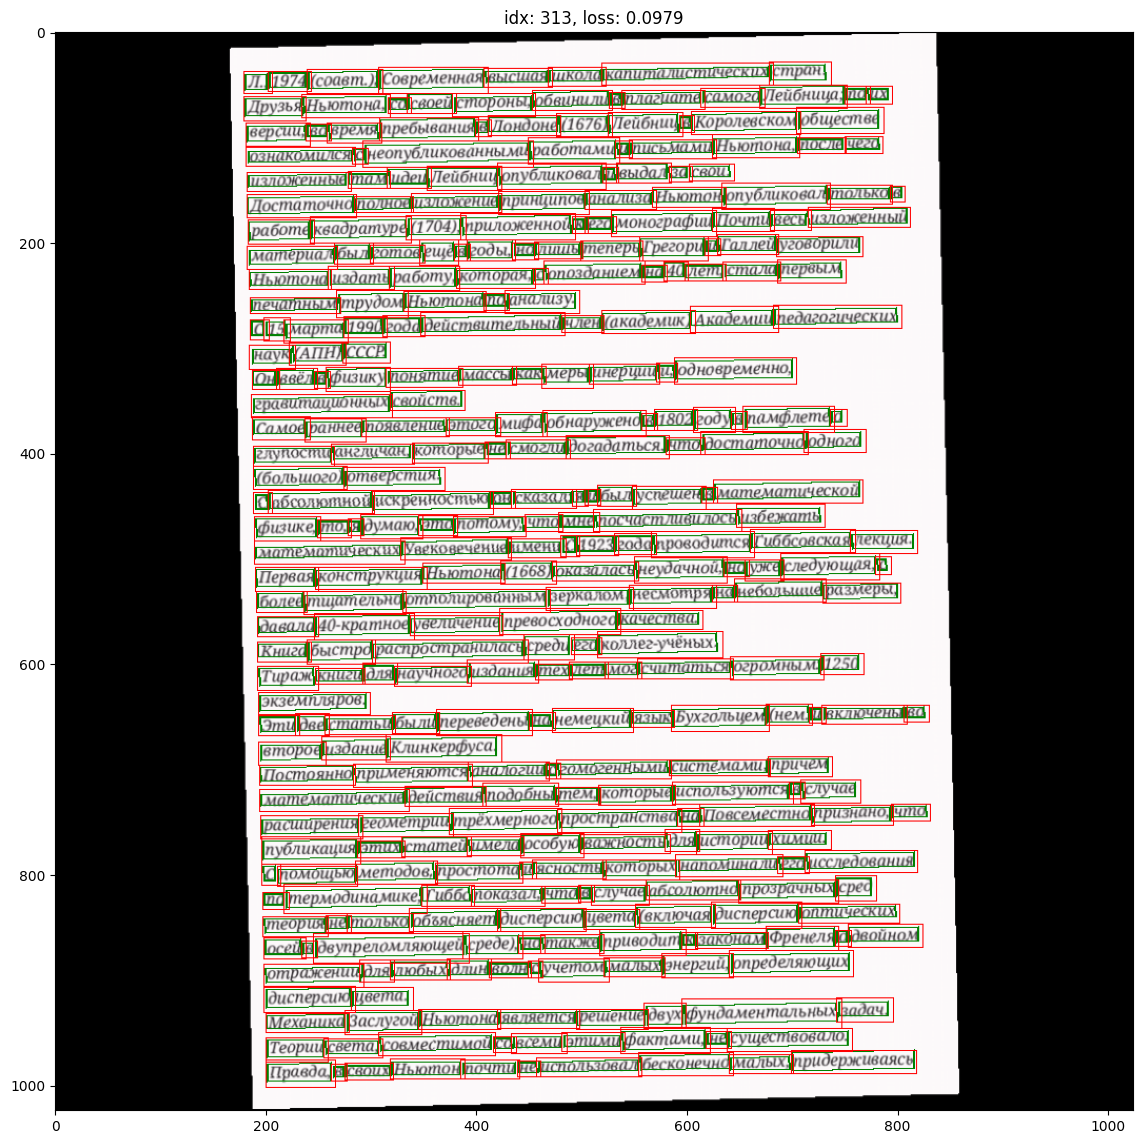

In [53]:
draw_image_dataset(val_set, NORMALIZE_PARAMS, model, img_size=14)